In [1]:
import pandas as pd
import os as os
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqIO import write
import statistics as stats
print("Ambiente bioinfo attivo! Tutti gli import necessari sono caricati.")

Ambiente bioinfo attivo! Tutti gli import necessari sono caricati.


Parametri di input:

- File path `file_fastq` del file FASTQ (dentro la cartella "data" del progetto)
- Lunghezza `k` dei k-mer
- Soglia di frequenza minima `frequencyThreshold` che permette di considerare un k-mer valido

In [2]:
file_fastq = 'data/input.fastq'
k = 6
frequencyThreshold=0.002

La funzione `parse_fastq` controlla l'esistenza del file, in caso contrario segnala un errore.
Successivamente costruisce una lista con le sequenze contenute in ciascuna read (`sequences`), una lista con le qualità per ogni base (`qualty_scores`) e una lista con gli identificativi di ogni read (`ids`).

In [3]:
def parse_fastq(file_fastq):
    
    if not os.path.exists(file_fastq):
        raise FileNotFoundError(f"File '{file_fastq}' non trovato.")
        
    reads = list(SeqIO.parse(file_fastq, "fastq")) 
    sequences = [str(r.seq) for r in reads] 
    quality_scores = [r.letter_annotations["phred_quality"] for r in reads]
    ids = [r.id for r in reads]
    reads_len = len(sequences[0]) if sequences else 0
    
    len_diverse = any(len(seq) != reads_len for seq in sequences)
    if len_diverse:
        print("Attenzione: reads con lunghezze diverse!")
    
    print(f"Sono stati letti {len(sequences)} reads, ciascuno di {reads_len} basi")
    return reads, sequences, quality_scores, ids, reads_len
    
reads, sequences, quality_scores, ids, reads_len = parse_fastq(file_fastq)

Sono stati letti 5000 reads, ciascuno di 152 basi


In [4]:
print("Esempio di read:")
print(reads[0])

print("\nEsempio di sequenza:")
print(sequences[0])

print("\nPunteggi di qualità della prima read:")
print(quality_scores[0])

print("\nEsempio di id della prima read:")
print(ids[0])

Esempio di read:
ID: SRR18961685.1
Name: SRR18961685.1
Description: SRR18961685.1 1 length=152
Number of features: 0
Per letter annotation for: phred_quality
Seq('TTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGTTTAGGGTTAGGG...CAA')

Esempio di sequenza:
TTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGTTTAGGGTTAGGGTTACGGATAGGGTAACGTGTAGCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCATAACCCTAACCCAA

Punteggi di qualità della prima read:
[31, 32, 30, 32, 34, 35, 33, 36, 34, 36, 36, 36, 34, 36, 34, 36, 36, 36, 34, 36, 34, 36, 36, 29, 31, 31, 34, 36, 36, 36, 34, 36, 34, 30, 36, 36, 34, 30, 34, 36, 36, 14, 14, 36, 34, 15, 36, 36, 14, 14, 25, 15, 36, 13, 14, 14, 34, 12, 31, 28, 10, 35, 25, 15, 13, 13, 34, 8, 35, 12, 30, 14, 14, 14, 25, 16, 31, 31, 31, 29, 32, 33, 34, 34, 35, 33, 34, 35, 35, 35, 36, 34, 35, 35, 35, 35, 35, 34, 35, 35, 35, 35, 36, 34, 35, 35, 35, 35, 36, 34, 35, 35, 35, 35, 36, 34, 35, 27, 35, 11, 35, 34, 35, 35, 10, 35, 36, 34, 11, 26, 35, 11, 21, 34, 35, 27, 11, 9, 13, 34, 1

La funzione `count_kmers` analizza tutti i read e costruisce una mappa di conteggi posizione specifica per ogni k-mer.

Per ogni k-mer, la funzione produce una lista in cui ogni elemento rappresenta il numero di read in cui quel k-mer inizia esattamente in quella posizione.

Ad esempio, se per il k-mer "TTAGGG" il valore alla posizione 2 è 5, significa che 5 read diversi contengono "TTAGGG" a partire dalla seconda posizione del read.

Esempio: *TTAGGG*: [1, 0, 0, 1, 0, 0, 1,...], *TAGGGT*: [2, 1, 1, 0, 1, 0,...]

In [5]:
def count_kmers(sequences, k, reads_len):
    
    kmer_counts = {}
    
    for index, seq in enumerate(sequences): 
        for pos in range(reads_len - k + 1): 
            kmer = seq[pos : pos + k] 

            if kmer not in kmer_counts:
                kmer_counts[kmer] = [0] * reads_len
                
            kmer_counts[kmer][pos] += 1 
    return kmer_counts

kmer_dict = count_kmers(sequences, k, reads_len)

print(f"\nDistribuzione di due k-mer campione")
keys = list(kmer_dict.keys())
kmer_1 = keys[0]
print(f"\nK-mer 1: '{kmer_1}'")
print(f"Frequenze per posizione: {kmer_dict[kmer_1][:20]}...")

kmer_2 = keys[1]
print(f"\nK-mer 2: '{kmer_2}'")
print(f"Frequenze per posizione: {kmer_dict[kmer_2][:20]}...")

print(f"\nRiepilogo statistico:")
print(f"K-mer unici identificati: {len(kmer_dict)}")
print(f"Lunghezza distribuzioni posizionali: {len(kmer_dict[kmer_1])} posizioni")


Distribuzione di due k-mer campione

K-mer 1: 'TTAGGG'
Frequenze per posizione: [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]...

K-mer 2: 'TAGGGT'
Frequenze per posizione: [2, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1]...

Riepilogo statistico:
K-mer unici identificati: 3876
Lunghezza distribuzioni posizionali: 152 posizioni


La funzione `filter_kmer_report` calcola la frequenza totale di ogni k-mer:

$$frequenza=\frac{\text{occorrenze totali k-mer}}{\text{numero di posizioni analizzate}}$$

Il filtraggio mantiene quindi solo i k‑mer la cui frequenza supera la soglia `frequencyThreshold`. Successivamente, viene creata una tabella che ordina i k‑mer significativi da quelli meno significativi.

In [6]:
def filter_kmer_report(kmer_dict, frequencyThreshold, total_pos):
    
    filtered_dict = {}
    list_rows = []
    top_kmer_list = [] 
    
    for kmer, pos_counts in kmer_dict.items():
        total_occurrences = sum(pos_counts) 
        frequency = total_occurrences / total_pos
        max_count = max(pos_counts) if pos_counts else 0
        best_pos = pos_counts.index(max_count) if pos_counts else 0
        included = frequency >= frequencyThreshold

        if included:
            filtered_dict[kmer] = pos_counts
            top_kmer_list.append((kmer, total_occurrences, best_pos, max_count))

        list_rows.append({
            "k-mer": kmer,
            "Occorrenze totali": total_occurrences,
            "Posizione max" : best_pos,
            "Occorrenze max": max_count,
            "Frequenza": round(frequency, 5),
            "Incluso": "Sì" if included else "No"
        })

    table_filtered = pd.DataFrame(list_rows) 
    table_filtered.sort_values(by="Frequenza", ascending=False, inplace=True) 
    table_filtered.reset_index(drop=True, inplace=True) 

    print("Tabella completa k-mer (con stato filtro):")
    display(table_filtered)

   
    if top_kmer_list:
        df_top = pd.DataFrame(top_kmer_list, columns=["k-mer", "Totale occorrenze", "Posizione max", "Occorrenze max"])
        df_top_sorted = df_top.sort_values(by="Occorrenze max", ascending=False).head(5)
        df_top_sorted.reset_index(drop=True, inplace=True)
        
        print("\nTop 5 k-mer filtrati (per occorrenze massime):")
        display(df_top_sorted)
    else:
        print("\nNessun k-mer ha superato il filtro di frequenza.")
        df_top_sorted = pd.DataFrame()

    return filtered_dict, list_rows, table_filtered, df_top_sorted
    
    
total_pos = (reads_len - k + 1) * len(sequences)

filtered_dict, list_rows, table_filtered, top5_table = filter_kmer_report(kmer_dict,frequencyThreshold, total_pos)

# Statistiche finali
print(f"\nStatistiche filtraggio:")
print(f"- K-mer totali analizzati: {len(kmer_dict)}")
print(f"- K-mer dopo filtraggio: {len(filtered_dict)}")

Tabella completa k-mer (con stato filtro):


,k-mer,Occorrenze totali,Posizione max,Occorrenze max,Frequenza,Incluso
0,TTTCCC,2106,66,32,0.00287,Sì
1,CTGCCT,2041,84,40,0.00278,Sì
2,CTCACT,2019,123,45,0.00275,Sì
3,GGGCAG,1936,133,47,0.00263,Sì
4,CTCTGG,1926,113,40,0.00262,Sì
...,...,...,...,...,...,...
3871,TGCTAT,1,72,1,0.00000,No
3872,GTATAA,1,74,1,0.00000,No
3873,CCTCTA,2,71,1,0.00000,No
3874,ACCGTA,2,31,1,0.00000,No



Top 5 k-mer filtrati (per occorrenze massime):


,k-mer,Totale occorrenze,Posizione max,Occorrenze max
0,ACTTCT,1925,119,61
1,GCAGAG,1843,135,47
2,CAGAGG,1726,136,47
3,GGGCAG,1936,133,47
4,GAGCCT,1563,142,46



Statistiche filtraggio:
- K-mer totali analizzati: 3876
- K-mer dopo filtraggio: 32


La funzione `find_max_kmer` individua il k-mer che ha il numero massimo di occorrenze in una singola posizione.
La funzione identifica: 

- k-ner dominante
- Posizione in cui il k-mer ha il valore massimo
- Il valore delle occorrence in quella posizione

In [7]:
def find_max_kmer(filtered_dict): 
    max_kmer, max_pos, max_count = None, None, 0
    
    for kmer, pos_counts in filtered_dict.items():
        for pos, count in enumerate(pos_counts):
            if count > max_count:
                max_kmer, max_pos, max_count = kmer, pos, count

    if max_kmer is None:
        print("Nessun k-mer dominante trovato.")
    return max_kmer, max_pos, max_count

max_kmer, max_pos, max_count = find_max_kmer(filtered_dict)  

table_max_kmer = pd.DataFrame({
    "k-mer dominante": [max_kmer],
    "Posizione max": [max_pos],
    "Occorrenze max": [max_count]
})

display(table_max_kmer)

,k-mer dominante,Posizione max,Occorrenze max
0,ACTTCT,119,61


La funzione `plot_kmer_distribution` crea un grafico a barre che mostra l'andamento delle occorrenze del k-mer dominante rispetto alle diverse posizioni che può assumere. 
La barra che individua la posizione in cui il k-mer è più frequente viene sottolineata da una linea tratteggiata in viola.

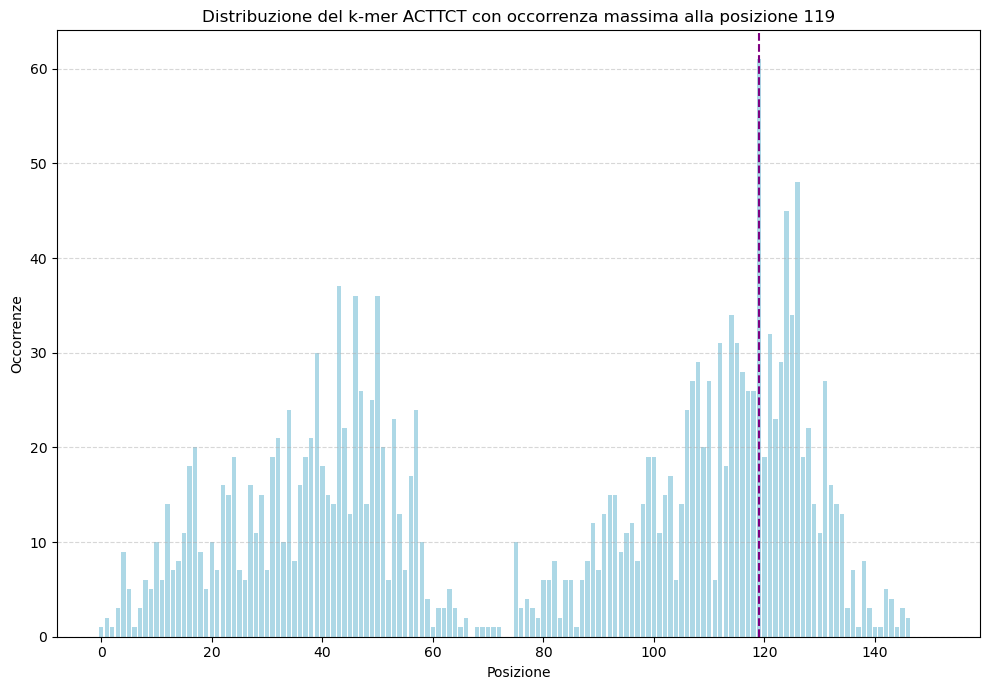

In [8]:
def plot_kmer_distribution(kmer, pos_counts, max_pos): 
    plt.figure(figsize=(10, 7))
    plt.bar(range(len(pos_counts)), pos_counts, color='lightblue')
    plt.axvline(x=max_pos, color='purple', linestyle='--')
    plt.xlabel("Posizione")
    plt.ylabel("Occorrenze")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.title(f"Distribuzione del k-mer {kmer} con occorrenza massima alla posizione {max_pos}")
    plt.tight_layout()
    plt.show()

if not filtered_dict:
    print("Nessun k-mer supera la soglia di frequenza da analizzare. Cambiare i parametri di configurazione.")
else:
    plot_kmer_distribution(max_kmer, filtered_dict[max_kmer], max_pos)

La funzione `output_fasta` estrae e salva in un file FASA tutte le reads che contengono il k-mer dominante nella posizione del suo picco massimo.
Ogni read che verrà salvata avrà anche come header la qualità media(media dei punteggi Pher) del read stesso.

In [9]:
def output_fasta(reads, quality_scores, max_kmer,max_pos, k, output_fasta):
    
    output = [] 
    
    for i, r in enumerate(reads):
        sequence = str(r.seq) 
        q = quality_scores[i]
        
        if sequence[max_pos:max_pos + k] == max_kmer:
            average = round(stats.mean(q), 2)
            newRecord = SeqRecord(Seq(sequence), id=f"{r.id} {average}", description="")
            output.append(newRecord)

    write(output, output_fasta, "fasta")
    print(f"Sono stati salvati {len(output)} reads in '{output_fasta}'.")

if max_kmer is not None and max_pos is not None:
    output_fasta(reads, quality_scores, max_kmer, max_pos, k, "output.fasta")
else:
    print("Impossibile generare output: k-mer dominante non identificato.")

Sono stati salvati 61 reads in 'output.fasta'.
